In [1]:
# load required libraries
options(stringsAsFactors = F)
suppressPackageStartupMessages({
library(Seurat)
library(ggplot2)
library(ggpubr)
library(dplyr)
library(Matrix)
library(Hmisc)
library(RColorBrewer)
library(ggrepel)
library(reshape2)
library(ggpubr)
library(pheatmap)
library(ggVolcano)
library(gtools)
})
set.seed(123)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”


In [2]:
# load the sample
sample <- readRDS("sample_mouse_TE_EHT.rds")
sample

An object of class Seurat 
51023 features across 5103 samples within 2 assays 
Active assay: SCT (17451 features, 3000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, tsne, umap

In [3]:
# set genes and TEs
TE_name <- grep(rownames(sample), pattern = "\\.LINE|\\.SINE|\\.LTR|\\.DNA", value = T)
length(TE_name)
gene_name <- setdiff(rownames(sample), TE_name)
length(gene_name)

[1] 1016

[1] 16435

In [4]:
# differential expression analysis pre-HEC vs VEC
prehec_vec_marker_genes <- FindMarkers(sample, features = gene_name, assay = "SCT", ident.1 = "pre-HEC", ident.2 = "VEC", only.pos = F, verbose = FALSE)
prehec_vec_marker_TEs <- FindMarkers(sample, features = TE_name, assay = "SCT", ident.1 = "pre-HEC", ident.2 = "VEC", only.pos = F, logfc.threshold = 0, verbose = FALSE)
write.csv(prehec_vec_marker_genes, "meta/prehec_vec_marker_genes_mouse.csv")
write.csv(prehec_vec_marker_TEs, "meta/prehec_vec_marker_TEs_mouse.csv")

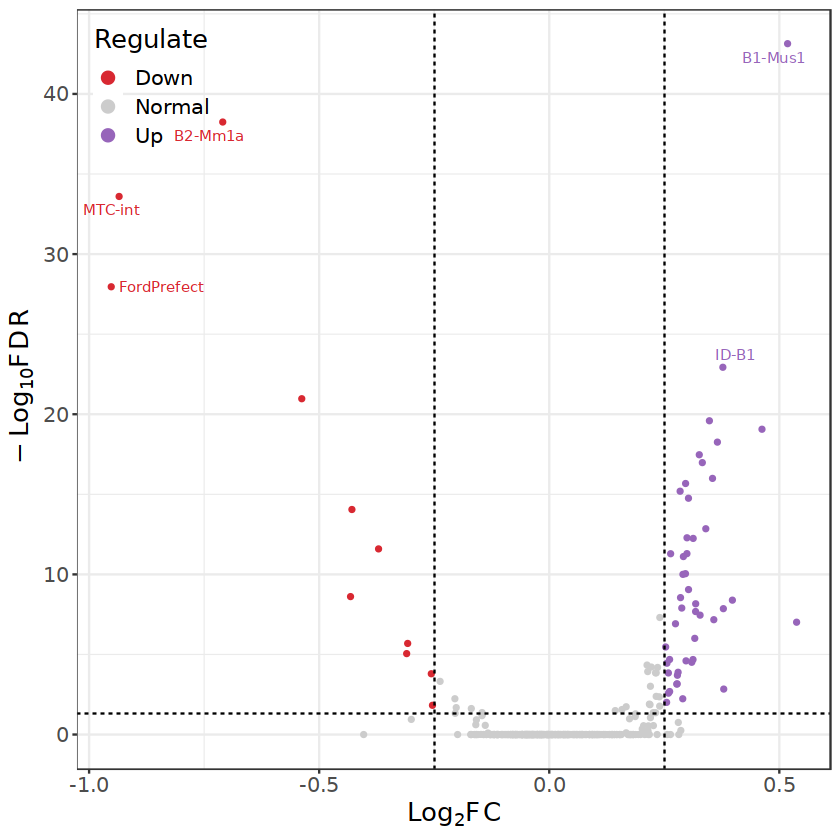

In [5]:
# draw the TE volcano plot pre-HEC vs VEC
data <- add_regulate(prehec_vec_marker_TEs, log2FC_name = "avg_log2FC", fdr_name = "p_val_adj", log2FC = 0.25, fdr = 0.05)
data$TE <- unlist(strsplit(rownames(data), split = "\\."))[seq(1, nrow(data) * 3, by = 3)]
ggvolcano(data, x = "log2FoldChange", y = "padj", label = "TE", label_number = 5, output = FALSE, log2FC_cut = 0.25, fills = c("#D82831", "grey80", "#9765BA"), colors = c("#D82831", "grey80", "#9765BA"))
ggsave("figure/TE_volcano_prehec_vec_mouse.pdf", width = 3, height = 2.5)

In [6]:
# differential expression analysis pre-HEC vs HSC
prehec_hsc_marker_genes <- FindMarkers(sample, features = gene_name, assay = "SCT", ident.1 = "pre-HEC", ident.2 = "HSC", only.pos = F, verbose = FALSE)
prehec_hsc_marker_TEs <- FindMarkers(sample, features = TE_name, assay = "SCT", ident.1 = "pre-HEC", ident.2 = "HSC", only.pos = F, logfc.threshold = 0, verbose = FALSE)
write.csv(prehec_hsc_marker_genes, "meta/prehec_hsc_marker_genes_mouse.csv")
write.csv(prehec_hsc_marker_TEs, "meta/prehec_hsc_marker_TEs_mouse.csv")

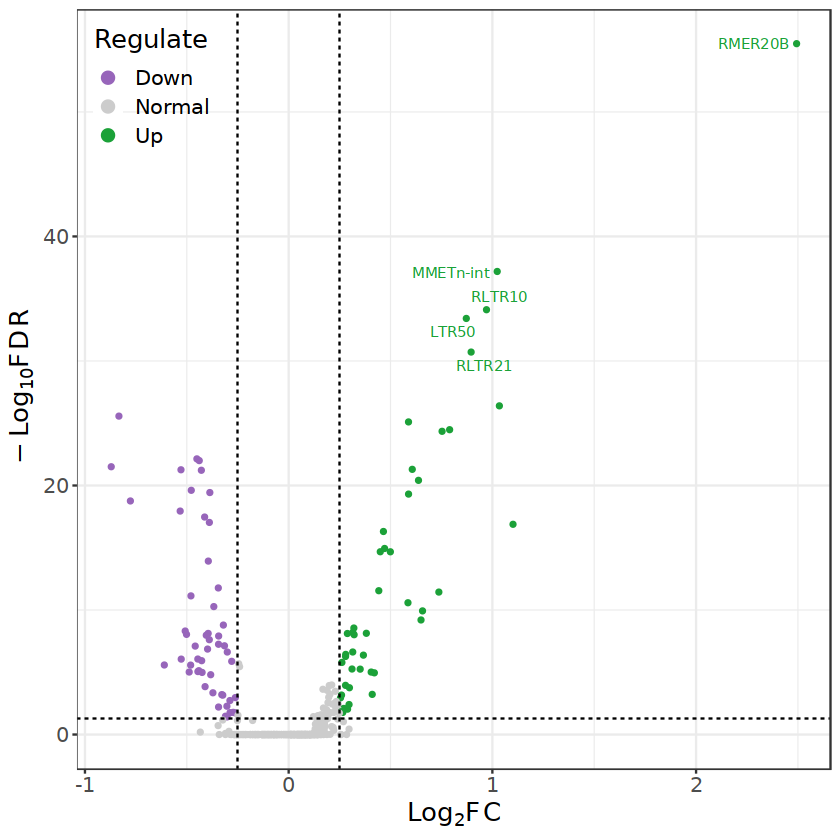

In [7]:
# draw the TE volcano plot pre-HEC vs HSC
prehec_hsc_marker_TEs$avg_log2FC <- -prehec_hsc_marker_TEs$avg_log2FC
data <- add_regulate(prehec_hsc_marker_TEs, log2FC_name = "avg_log2FC", fdr_name = "p_val_adj", log2FC = 0.25, fdr = 0.05)
data$TE <- unlist(strsplit(rownames(data), split = "\\."))[seq(1, nrow(data) * 3, by = 3)]
ggvolcano(data, x = "log2FoldChange", y = "padj", label = "TE", label_number = 5, output = FALSE, log2FC_cut = 0.25, fills = c("#9765BA", "grey80", "#1BA138"), colors = c("#9765BA", "grey80", "#1BA138"))
ggsave("figure/TE_volcano_prehec_hsc_mouse.pdf", width = 3, height = 2.5)

In [8]:
# fold change pre-HEC vs VEC and HSC
prehec_vec_fc <- FoldChange(sample, features = gene_name, `ident.1` = "pre-HEC", ident.2 = "VEC", assay = "SCT")
prehec_vec_fc_down <- subset(prehec_vec_fc, avg_log2FC < 0)
prehec_hsc_fc <- FoldChange(sample, features = gene_name, `ident.1` = "pre-HEC", ident.2 = "HSC", assay = "SCT")
prehec_hsc_fc_down <- subset(prehec_hsc_fc, avg_log2FC < 0)

In [9]:
# get pre-HEC down-regulated degs
prehec_vec_marker_genes_significant <- subset(prehec_vec_marker_genes, avg_log2FC <= -0.25 & p_val_adj <= 0.05)
prehec_hsc_marker_genes_significant <- subset(prehec_hsc_marker_genes, avg_log2FC <= -0.25 & p_val_adj <= 0.05)

[1] 342

[1] 265

[1] "Zfp984" "Zfp445"

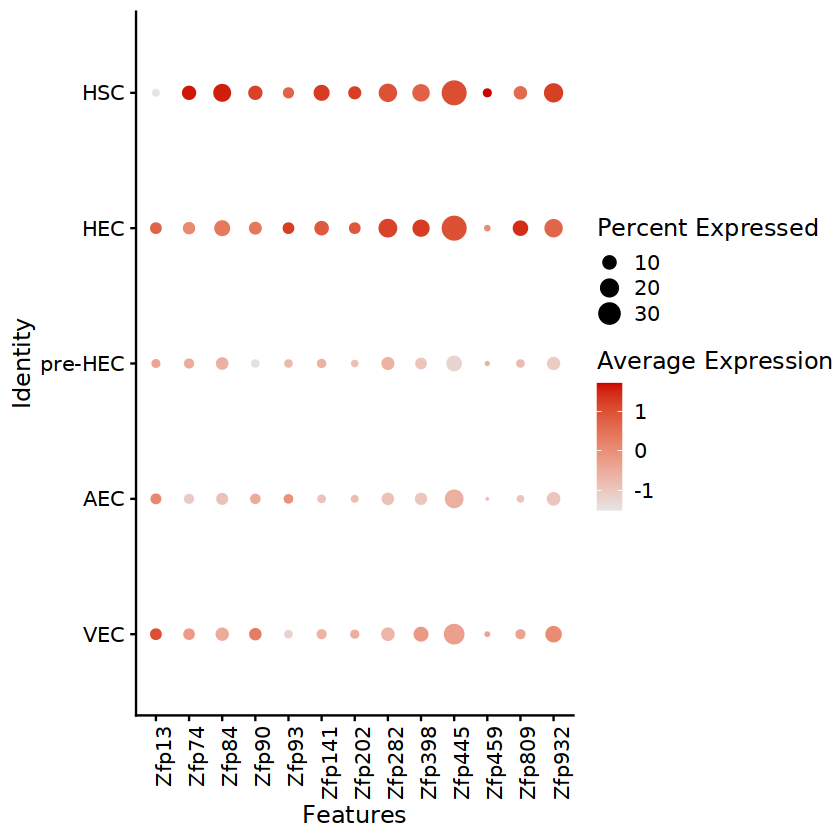

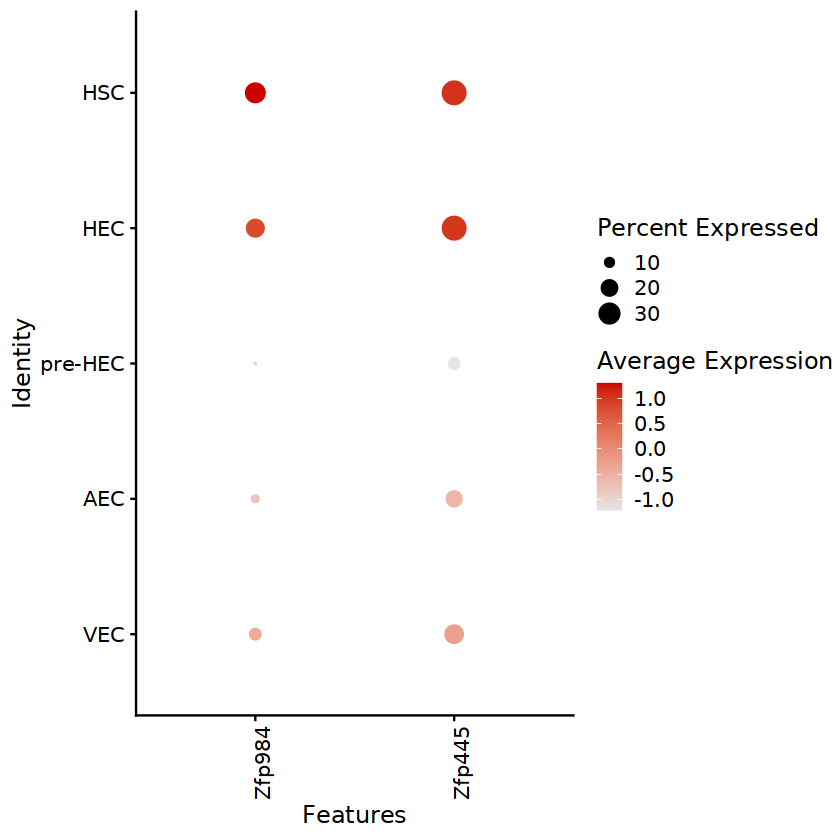

In [10]:
# krab-zfps signatures
krab_zfps_table <- read.csv("meta/KRAB-ZFPS-mouse.csv")
krab_zfps <- intersect(krab_zfps_table$Gene.symbol, rownames(sample@assays$RNA@counts))
length(krab_zfps)

#krab_zfps <- grep(rownames(sample), pattern = "^Znf|^Zfp", value = T)
krab_zfps_down <- intersect(krab_zfps, unique(c(rownames(prehec_vec_fc_down), rownames(prehec_hsc_fc_down))))
length(krab_zfps_down)
krab_zfps_pub <- mixedsort(unique(c("Zfp708","Zfp809","Zfp932","Zfp459","Zfp819","Zfp13","Zfp69","Zfp90","Zfp445","Zfp91","Zfp93","Zfp649","Zfp765","Zfp141","Zfp84","Zfp202","Zfp282","Zfp398","Zfp274","Zfp75D","Zfp589","Zfp268","Zfp224","Zfp255","Zfp74")))
krab_zfps_down_selected <- intersect(krab_zfps_pub, krab_zfps_down)
DotPlot(sample, features = krab_zfps_down_selected, cols=c("grey90","red3"), scale.by = "size") + theme(axis.text.x=element_text(angle=90, hjust=1))

krab_zfps_significant <- intersect(krab_zfps, unique(c(rownames(prehec_vec_marker_genes_significant), rownames(prehec_hsc_marker_genes_significant))))
krab_zfps_significant <- setdiff(krab_zfps_significant, 'B230307C23Rik')
krab_zfps_significant

DotPlot(sample, features = krab_zfps_significant, cols=c("grey90","red3"), scale.by = "size") + theme(axis.text.x=element_text(angle=90, hjust=1))

[1] "Dnmt1"  "Dnmt3a" "Dnmt3b" "Uhrf1"  "Usp7"

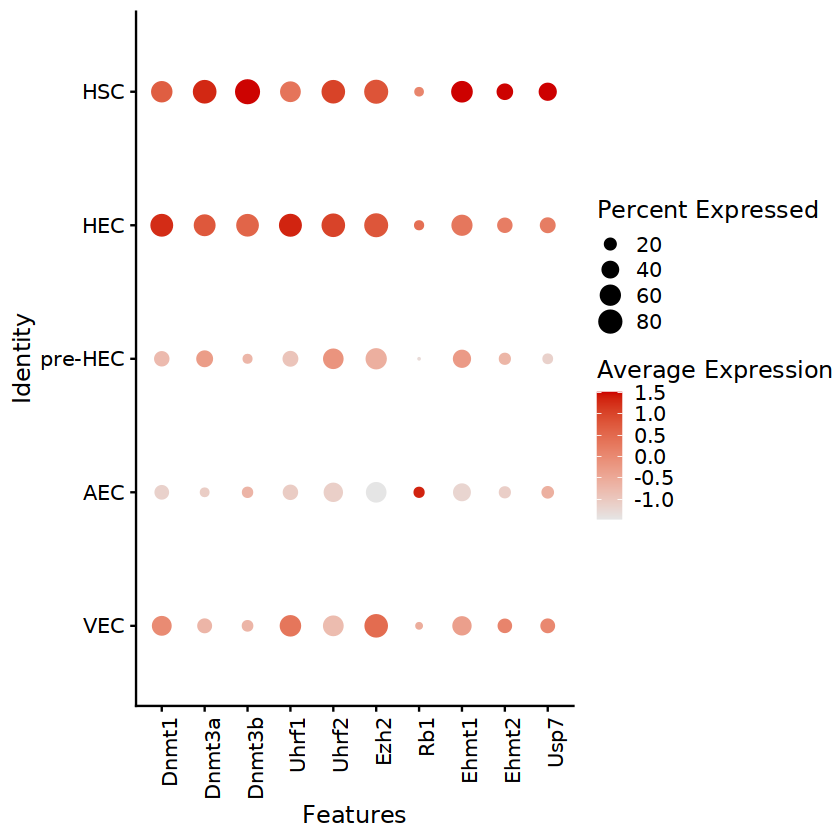

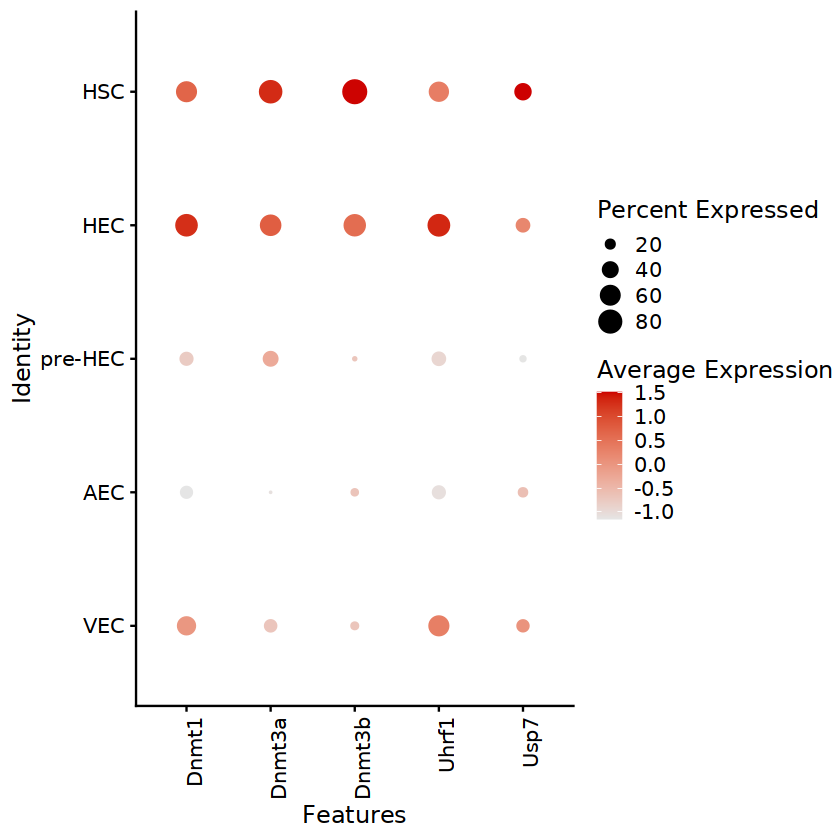

In [11]:
# DNMT complex signatures
dnmts <- capitalize(tolower(c("DNMT1","DNMT3A","DNMT3B","UHRF1","UHRF2","EZH2","HDAC1","RB1","EHMT1","EHMT2","USP7")))
dnmts_down <- intersect(dnmts, unique(c(rownames(prehec_vec_fc_down), rownames(prehec_hsc_fc_down))))
DotPlot(sample, features = dnmts_down, cols=c("grey90","red3"), scale.by = "size") + theme(axis.text.x=element_text(angle=90, hjust=1))

dnmts_significant <- intersect(dnmts, c(rownames(prehec_vec_marker_genes_significant), rownames(prehec_hsc_marker_genes_significant)))
dnmts_significant
DotPlot(sample, features = dnmts_significant, cols=c("grey90","red3"), scale.by = "size") + theme(axis.text.x=element_text(angle=90, hjust=1))

[1] "Rbbp7" "Mta1"  "Mta2"  "Mbd3"  "Chd4"

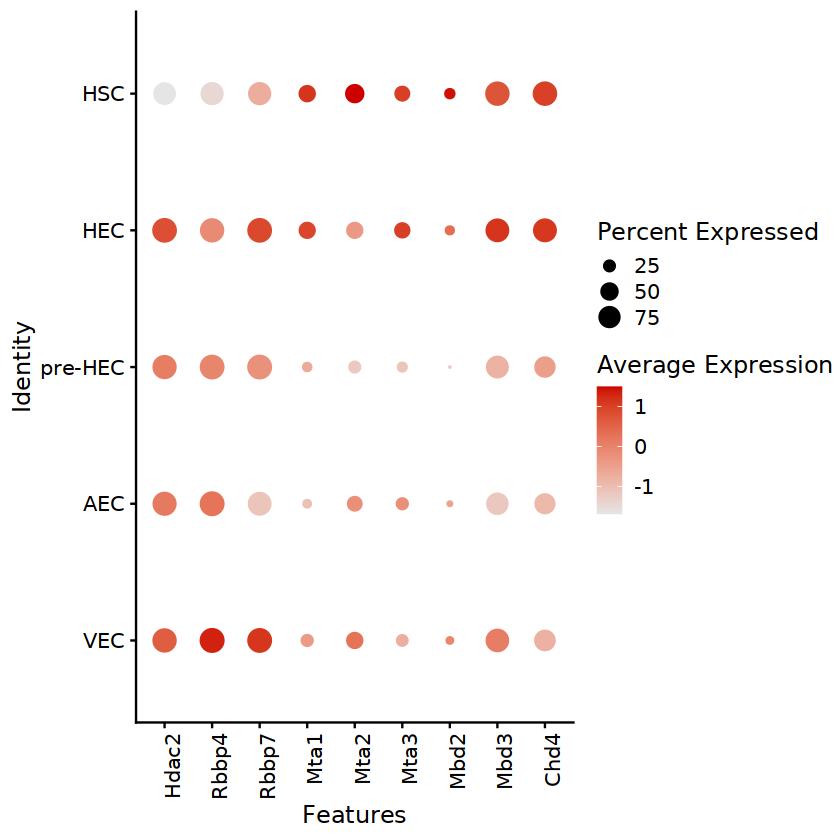

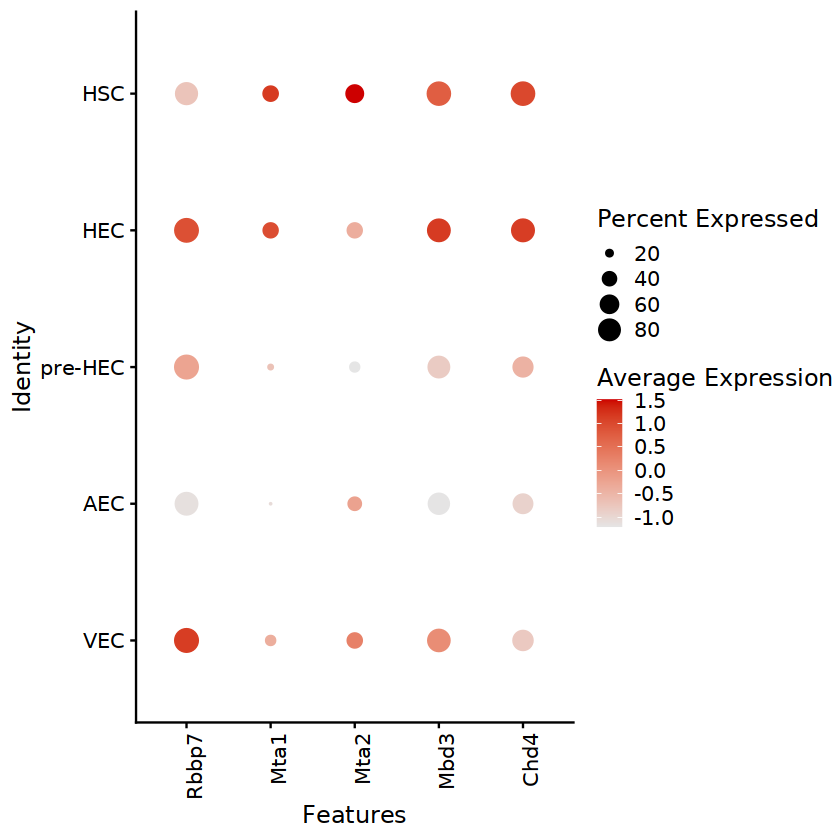

In [12]:
# NuRD complex
nurds <- capitalize(tolower(c("HDAC1","HDAC2","RBBP4","RBBP7","MTA1","MTA2","MTA3","MBD2","MBD3","CHD3","CHD4","CHD5")))
nurds_down <- intersect(nurds, unique(c(rownames(prehec_vec_fc_down), rownames(prehec_hsc_fc_down))))
DotPlot(sample, features = nurds_down, cols=c("grey90","red3"), scale.by = "size") + theme(axis.text.x=element_text(angle=90, hjust=1))

nurds_significant <- intersect(nurds, c(rownames(prehec_vec_marker_genes_significant), rownames(prehec_hsc_marker_genes_significant)))
nurds_significant
DotPlot(sample, features = nurds_significant, cols=c("grey90","red3"), scale.by = "size") + theme(axis.text.x=element_text(angle=90, hjust=1))

character(0)

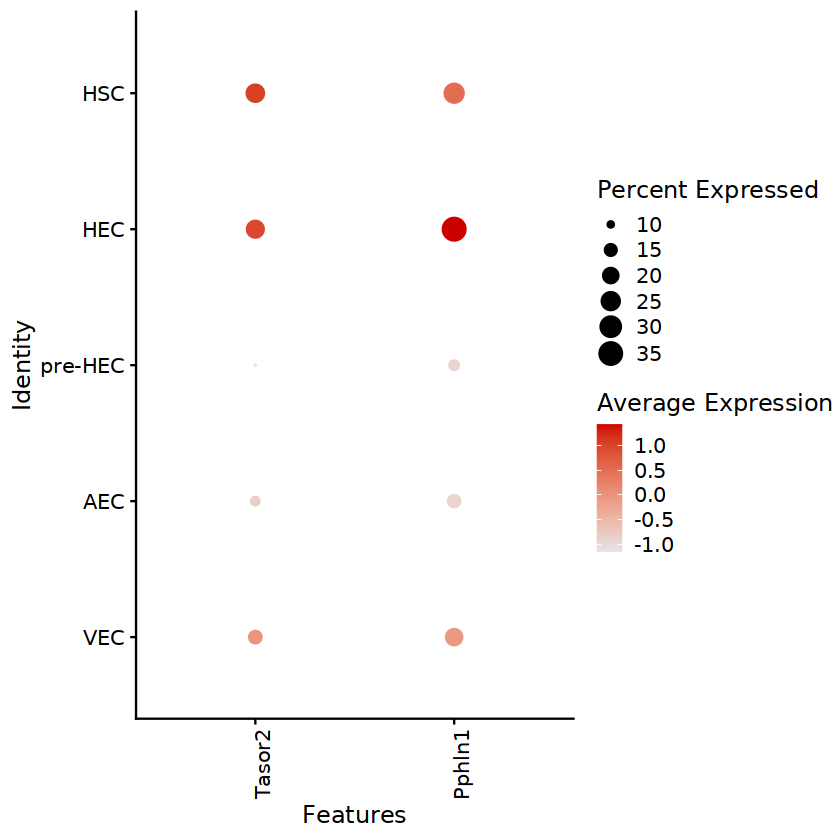

In [13]:
# HUSH complex
hushs <- capitalize(tolower(c("TASOR2","MPHOSPH8","PPHLN1","MORC2")))
hushs_down <- intersect(hushs, unique(c(rownames(prehec_vec_fc_down), rownames(prehec_hsc_fc_down))))
DotPlot(sample, features = hushs_down, cols=c("grey90","red3"), scale.by = "size") + theme(axis.text.x=element_text(angle=90, hjust=1))

hushs_significant <- intersect(hushs, c(rownames(prehec_vec_marker_genes_significant), rownames(prehec_hsc_marker_genes_significant)))
hushs_significant
#DotPlot(sample, features = hushs_significant, cols=c("grey90","red3"), scale.by = "size") + theme(axis.text.x=element_text(angle=90, hjust=1))

character(0)

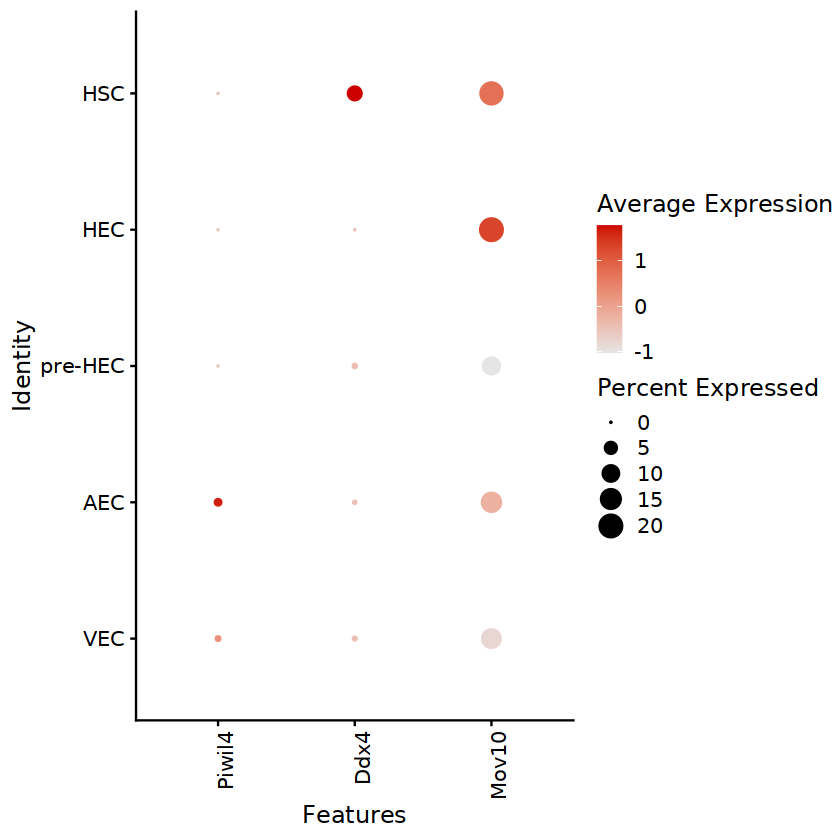

In [14]:
# PIWI complex
piwis <- capitalize(tolower(c("PIWIL1","PIWIL2","PIWIL3","PIWIL4","DDX4","MOV10","MOV10L1","GTSF1","GTSF1L")))
piwis_down <- intersect(piwis, unique(c(rownames(prehec_vec_fc_down), rownames(prehec_hsc_fc_down))))
DotPlot(sample, features = piwis_down, cols=c("grey90","red3"), scale.by = "size") + theme(axis.text.x=element_text(angle=90, hjust=1))

piwis_significant <- intersect(piwis, c(rownames(prehec_vec_marker_genes_significant), rownames(prehec_hsc_marker_genes_significant)))
piwis_significant
# DotPlot(sample, features = piwis_significant, cols=c("grey90","red3"), scale.by = "size") + theme(axis.text.x=element_text(angle=90, hjust=1))

[1] "Trim28" "Cbx3"

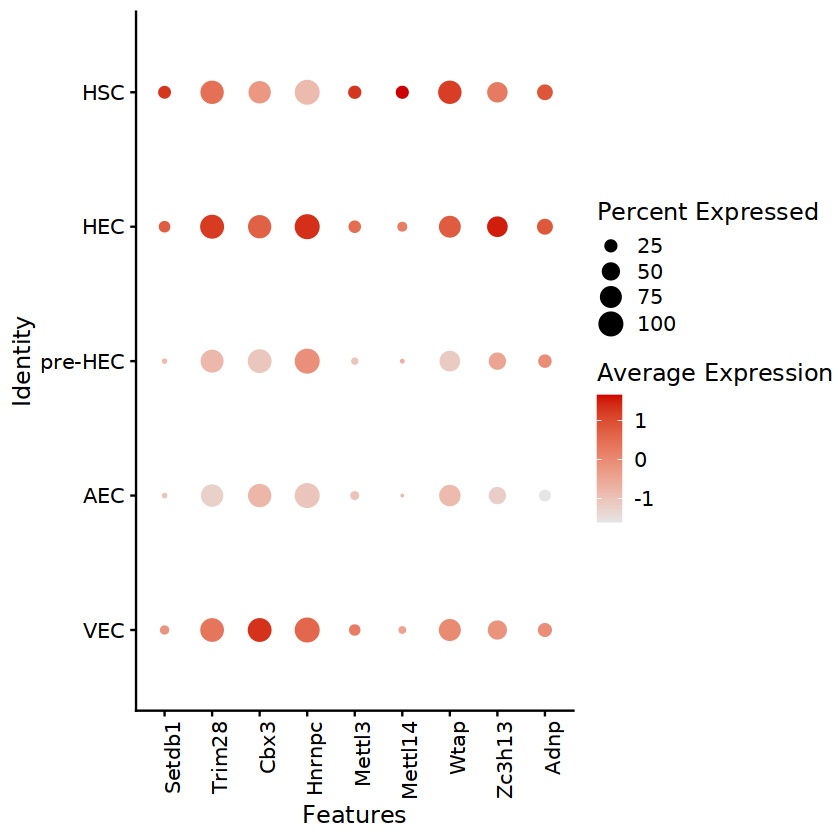

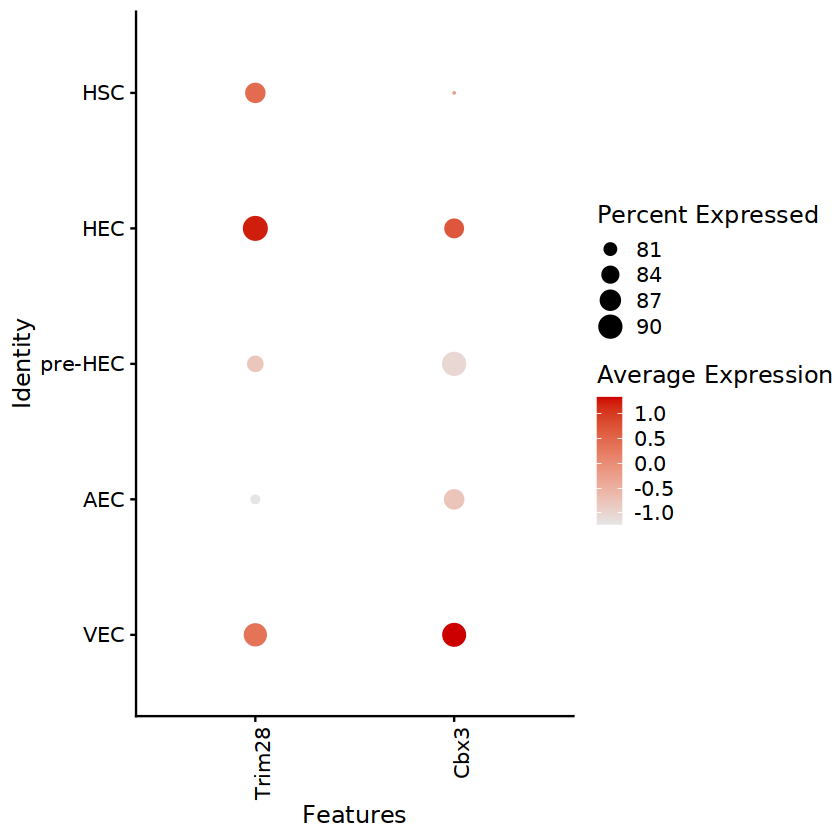

In [15]:
# Other TE suppressors
others <- capitalize(tolower(c("SETDB1","TRIM28","CBX1","CBX3","HNRNPC","METTL3","METTL14","WTAP","ZC3H13","ADNP")))
others_down <- intersect(others, unique(c(rownames(prehec_vec_fc_down), rownames(prehec_hsc_fc_down))))
DotPlot(sample, features = others_down, cols=c("grey90","red3"), scale.by = "size") + theme(axis.text.x=element_text(angle=90, hjust=1))

others_significant <- intersect(others, unique(c(rownames(prehec_vec_marker_genes_significant), rownames(prehec_hsc_marker_genes_significant))))
others_significant

DotPlot(sample, features = others_significant, cols=c("grey90","red3"), scale.by = "size") + theme(axis.text.x=element_text(angle=90, hjust=1))

In [16]:
# average expression for all TE silencers
te_silencer_all_exp <- AverageExpression(sample, assays = "SCT", group.by = "celltype", features = unique(c(mixedsort(krab_zfps), dnmts, nurds, hushs, piwis, others)))
te_silencer_all_exp <- as.data.frame(te_silencer_all_exp$SCT)
te_silencer_all_exp$Down <- "FALSE"
te_silencer_all_exp[unique(c(mixedsort(krab_zfps_down), dnmts_down, nurds_down, hushs_down, piwis_down, others_down)), "Down"] <- "TRUE"
te_silencer_all_exp$Significant <- "FALSE"
te_silencer_all_exp[unique(c(mixedsort(krab_zfps_significant), dnmts_significant, nurds_significant, hushs_significant, piwis_significant, others_significant)), "Significant"] <- "TRUE"
write.csv(te_silencer_all_exp, "meta/TE_silencers_all_average_expression_mouse.csv")

Warning message:
“The following 64 features were not found in the SCT assay: 1700020N01Rik, 2410141K09Rik, EU599041, Gm2004, Gm2007, Gm2026, Gm2381, Gm4767, Gm5751, Gm6592, Gm6871, Gm10324, Gm10778, Gm11007, Gm11008, Gm11009, Gm14401, Gm14406, Gm14408, Gm14412, Gm14435, Gm14440, Gm14444, Gm14459, Gm17067, Rex2, Ssx9, Ssxa1, Ssxb1, Ssxb2, Ssxb3, Ssxb5, Ssxb8, Ssxb9, Ssxb10, Zfp92, Zfp534, Zfp600, Zfp616, Zfp641, Zfp663, Zfp708, Zfp735, Zfp819, Zfp872, Zfp936, Zfp965, Zfp969, Zfp978, Zfp980, Zfp981, Zfp986, Zfp987, Zfp988, Zfp989, Zkscan16, Chd5, Morc2, Piwil1, Piwil2, Piwil3, Mov10l1, Gtsf1, Gtsf1l”


In [17]:
# plot the dotplot for TE silencers
te_silencers_all <- intersect(unique(c(mixedsort(krab_zfps), dnmts, nurds, hushs, piwis, others)), rownames(sample))
p <- DotPlot(sample, features = rev(te_silencers_all), cols=c("grey90","red3"), scale.by = "size") + coord_flip() + theme(axis.text.x=element_text(angle=90, hjust=1))
png("figure/dotplot_TE_silencers_all_mouse.png", width = 500, height = 7000)
print(p)
dev.off()

png 
  2

In [18]:
# TE silencer heatmap
te_silencer_down_exp <- AverageExpression(sample, assays = "SCT", group.by = "celltype", features = unique(c(mixedsort(c(krab_zfps_down_selected, krab_zfps_significant)), dnmts_down, nurds_down, hushs_down, piwis_down, others_down)))
nrow(te_silencer_down_exp$SCT)
cc = colorRampPalette(rev(brewer.pal(n = 7, name = "PuOr")))
pheatmap(te_silencer_down_exp$SCT, cluster_rows = F, cluster_cols = F, scale = "row", color = cc(100), filename = "figure/TE_silencer_heatmap_mouse.pdf", width = 3, height = 8.5, border_color = "white")

[1] 47

In [19]:
# score the TE silencing gene sets
te_silencer_list <- list(KZFP = krab_zfps_down_selected, DNMT = dnmts_down, NURD = nurds_down, HUSH = hushs_down, PIWI = piwis_down)
sample_score <- sample
sample_score <- AddModuleScore(sample_score, features = te_silencer_list, assay = "SCT")
colnames(sample_score@meta.data)[13:17] <- names(te_silencer_list)

# score all TE silencer modules
te_silencer_all_list <- list(ALL = c(krab_zfps_down, dnmts_down, nurds_down, hushs_down, piwis_down))
sample_score <- AddModuleScore(sample_score, features = te_silencer_all_list, assay = "SCT")
colnames(sample_score@meta.data)[18] <- names(te_silencer_all_list)

In [20]:
# score TEs in MME5 (kME >= 0.5)
te_module_mm10 <- read.csv("meta/te_module_mm10.csv", row.names = 1)
te_mme5_good <- rownames(subset(te_module_mm10, kME >= 0.3))
length(te_mme5_good)
te_mme5_good_list <- list(TEs_MME5 = te_mme5_good)
sample_score <- AddModuleScore(sample_score, features = te_mme5_good_list, assay = "SCT")
colnames(sample_score@meta.data)[19] <- names(te_mme5_good_list)

[1] 179

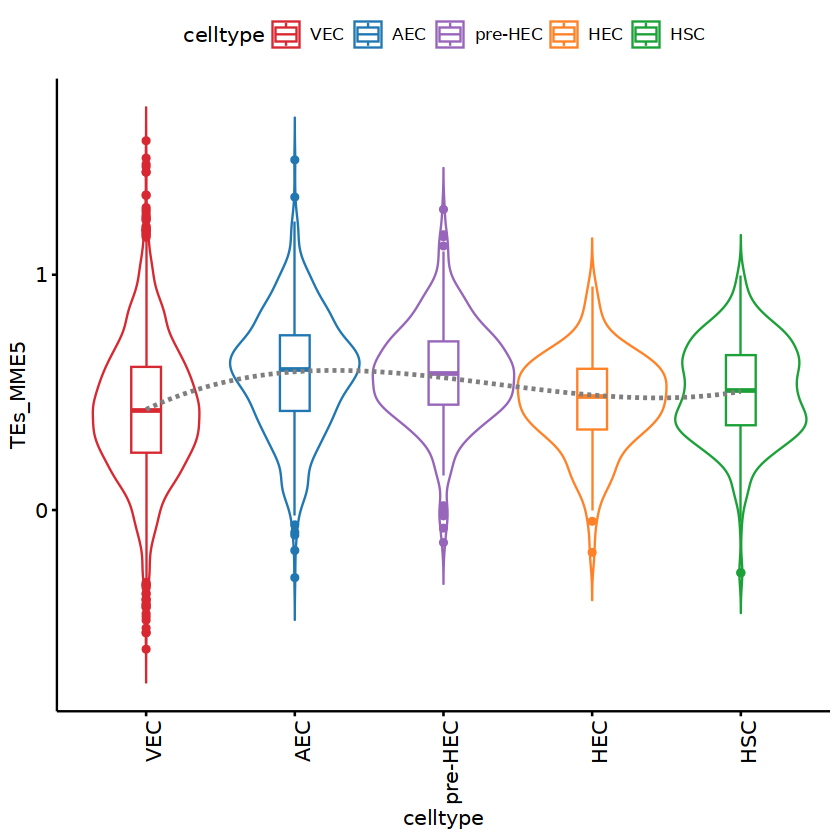

In [21]:
# plot MME5 TEs module score
ggviolin(sample_score@meta.data, x = "celltype", y = "TEs_MME5", add = c("boxplot"), color = "celltype", palette = c("#D82831", "#2077B2", "#9765BA", "#FF8228", "#1BA138")) + geom_smooth(method = lm, formula = y ~ splines::bs(x, 3), color = "grey50", linetype = "dashed", se = FALSE, aes(group=1)) + theme(axis.text.x=element_text(angle=90, hjust=1))
ggsave("figure/module_score_MME5_TEs_mouse.pdf", width = 2.5, height = 3.5)

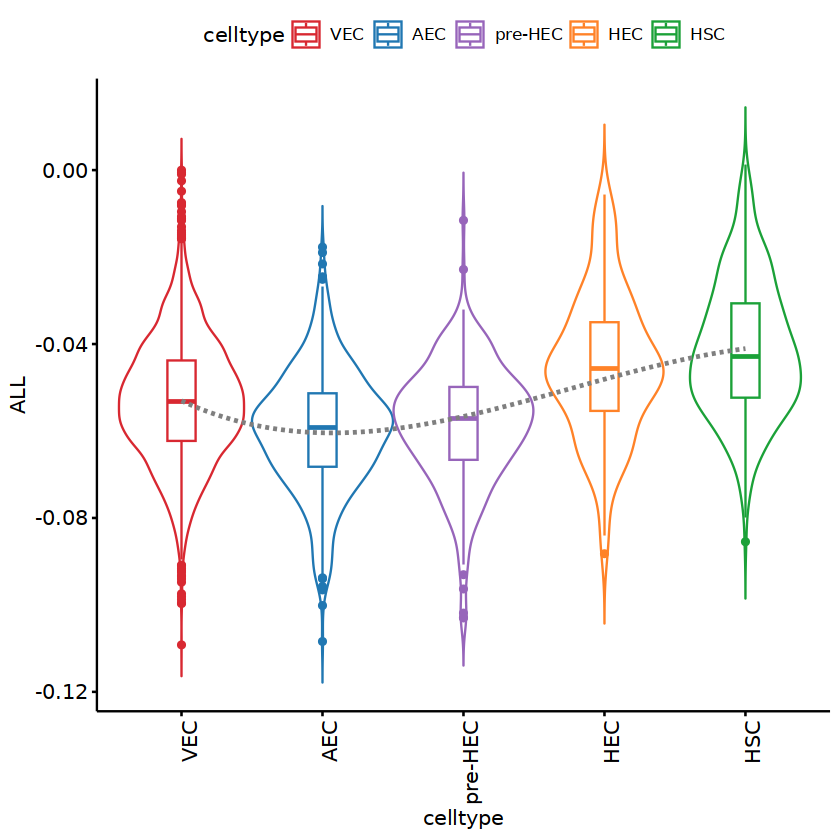

In [22]:
# plot all TE silencers module score
ggviolin(sample_score@meta.data, x = "celltype", y = "ALL", add = c("boxplot"), color = "celltype", palette = c("#D82831", "#2077B2", "#9765BA", "#FF8228", "#1BA138")) + geom_smooth(method = lm, formula = y ~ splines::bs(x, 3), color = "grey50", linetype = "dashed", se = FALSE, aes(group=1)) + theme(axis.text.x=element_text(angle=90, hjust=1))
ggsave("figure/module_score_ALL_mouse.pdf", width = 2.5, height = 3.5)

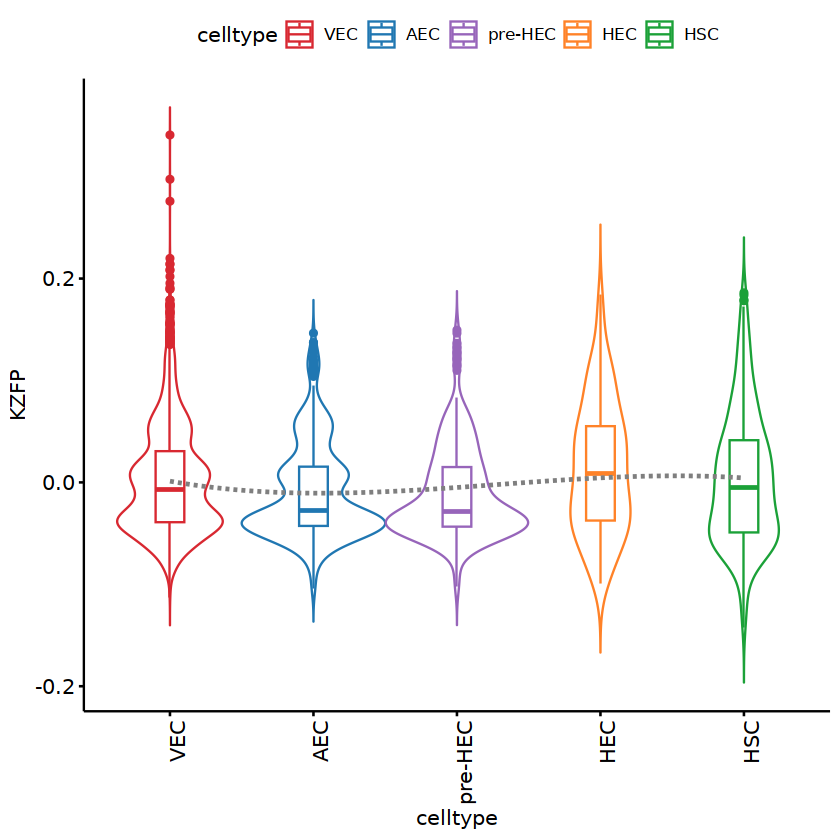

In [23]:
# plot KZFP module score
ggviolin(sample_score@meta.data, x = "celltype", y = "KZFP", add = c("boxplot"), color = "celltype", palette = c("#D82831", "#2077B2", "#9765BA", "#FF8228", "#1BA138")) + geom_smooth(method = lm, formula = y ~ splines::bs(x, 3), color = "grey50", linetype = "dashed", se = FALSE, aes(group=1)) + theme(axis.text.x=element_text(angle=90, hjust=1))
ggsave("figure/module_score_KZFP_mouse.pdf", width = 2.5, height = 3.5)

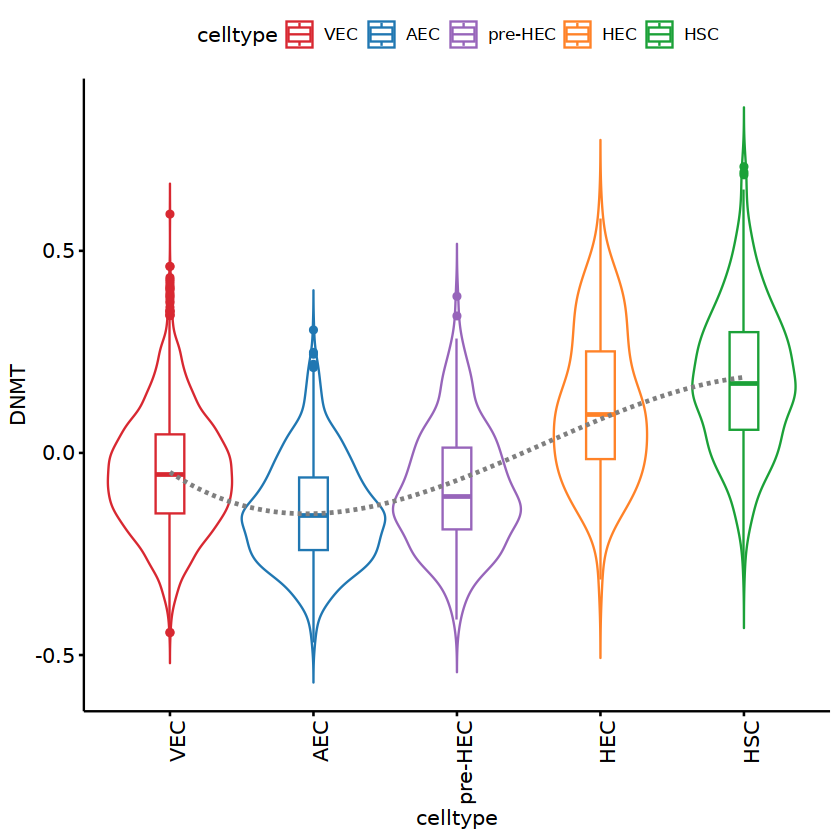

In [24]:
# plot DNMT module score
ggviolin(sample_score@meta.data, x = "celltype", y = "DNMT", add = c("boxplot"), color = "celltype", palette = c("#D82831", "#2077B2", "#9765BA", "#FF8228", "#1BA138")) + geom_smooth(method = lm, formula = y ~ splines::bs(x, 3), color = "grey50", linetype = "dashed", se = FALSE, aes(group=1)) + theme(axis.text.x=element_text(angle=90, hjust=1))
ggsave("figure/module_score_DNMT_mouse.pdf", width = 2.5, height = 3.5)

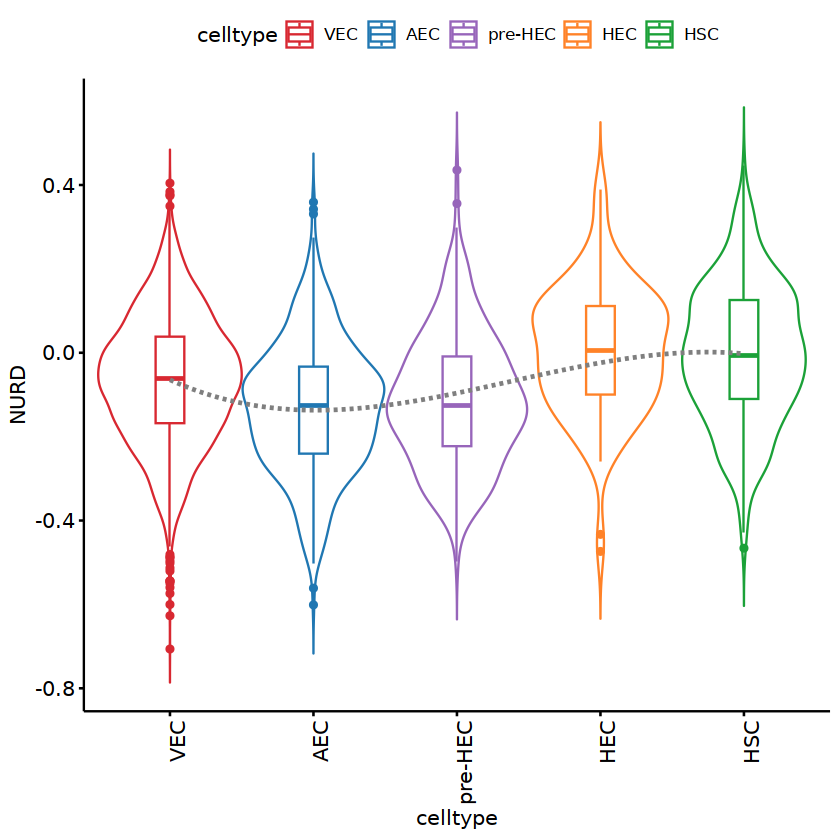

In [25]:
# plot NURD module score
ggviolin(sample_score@meta.data, x = "celltype", y = "NURD", add = c("boxplot"), color = "celltype", palette = c("#D82831", "#2077B2", "#9765BA", "#FF8228", "#1BA138")) + geom_smooth(method = lm, formula = y ~ splines::bs(x, 3), color = "grey50", linetype = "dashed", se = FALSE, aes(group=1)) + theme(axis.text.x=element_text(angle=90, hjust=1))
ggsave("figure/module_score_NURD_mouse.pdf", width = 2.5, height = 3.5)

In [26]:
# load latent time predicted by scvelo
latent_time <- read.csv("meta/latent_time_mouse_EHT.csv")
cellid <- unlist(strsplit(latent_time$CellID, ":"))[seq(2, nrow(latent_time) * 2, by = 2)]
cellid <- gsub(pattern = "x-0", replacement = "-1_1", cellid)
cellid <- gsub(pattern = "x-1", replacement = "-1_2", cellid)
cellid <- gsub(pattern = "x-2", replacement = "-1_3", cellid)
rownames(latent_time) <- cellid

sample_score$latent_time <- latent_time[colnames(sample_score), ]$latent_time

# down sampling VEC
set.seed(123)
bars1 <- sample(colnames(sample_score)[Idents(sample_score) %in% c("VEC")], 300) 
bars2 <- colnames(sample_score)[Idents(sample_score) %in% c("AEC", "pre-HEC", "HEC", "HSC")]
sample_score_plot <- subset(sample_score, cells=c(bars1, bars2))

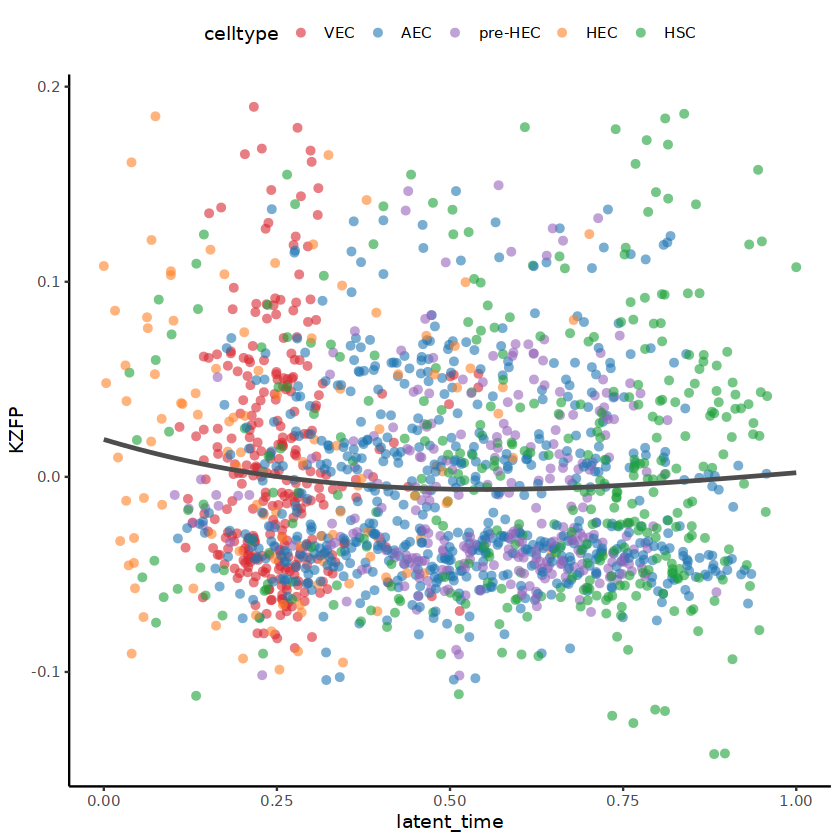

In [27]:
# plot the KZFP module
ggplot(sample_score_plot@meta.data, aes(latent_time, KZFP, color = celltype))+ geom_point(alpha = 0.6, stroke = NA, size = 2.5) + geom_smooth(method = lm, formula = y ~ splines::bs(x, 3), color = "grey30", se = FALSE) + theme_classic() + theme(legend.position="top") + scale_color_manual(values = c("#D82831", "#2077B2", "#9765BA", "#FF8228", "#1BA138"))
ggsave("figure/kzfp_trend_mouse.pdf", width = 5, height = 5)

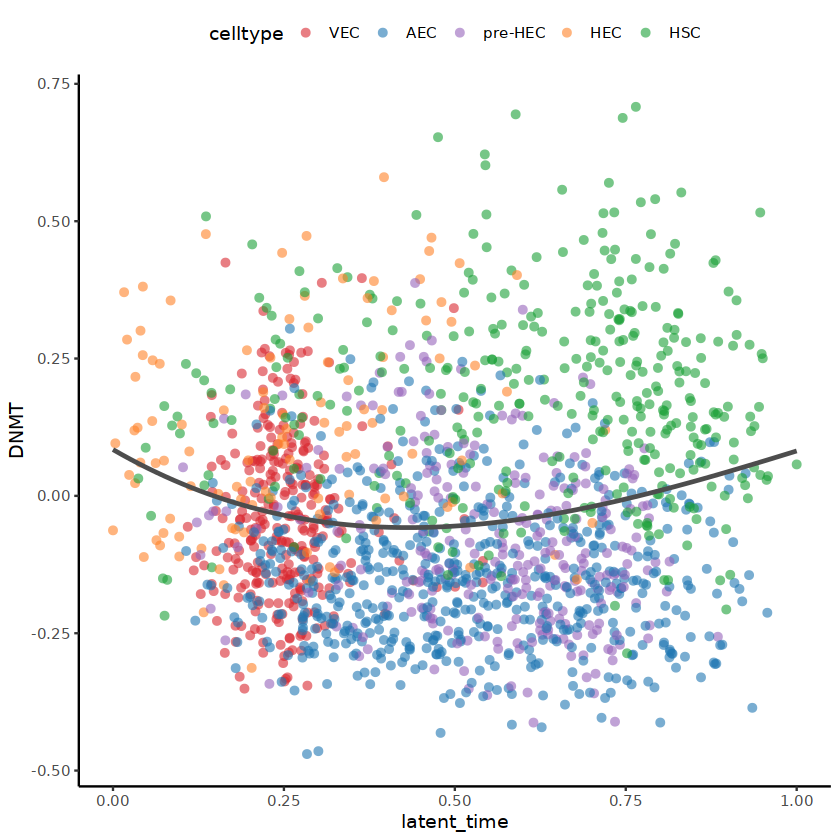

In [28]:
# plot the DNMT module
ggplot(sample_score_plot@meta.data, aes(latent_time, DNMT, color = celltype))+ geom_point(alpha = 0.6, stroke = NA, size = 2.5) + geom_smooth(method = lm, formula = y ~ splines::bs(x, 3), color = "grey30", se = FALSE) + theme_classic() + theme(legend.position="top") + scale_color_manual(values = c("#D82831", "#2077B2", "#9765BA", "#FF8228", "#1BA138"))
ggsave("figure/dnmt_trend_mouse.pdf", width = 5, height = 5)

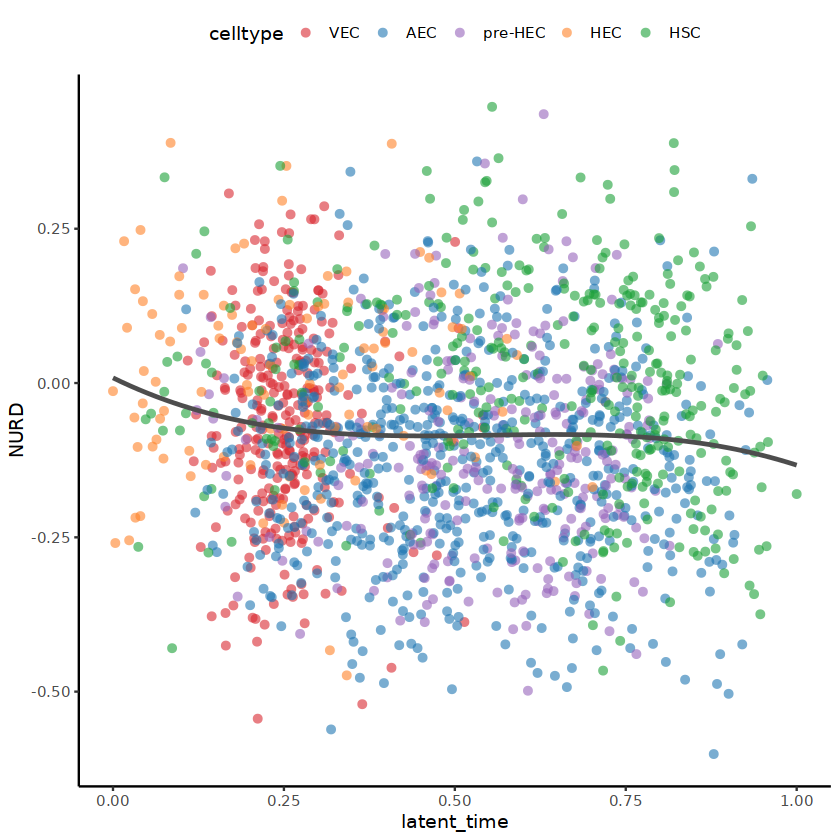

In [29]:
# plot the NURD module
ggplot(sample_score_plot@meta.data, aes(latent_time, NURD, color = celltype))+ geom_point(alpha = 0.6, stroke = NA, size = 2.5) + geom_smooth(method = lm, formula = y ~ splines::bs(x, 3), color = "grey30", se = FALSE) + theme_classic() + theme(legend.position="top") + scale_color_manual(values = c("#D82831", "#2077B2", "#9765BA", "#FF8228", "#1BA138"))
ggsave("figure/nurd_trend_mouse.pdf", width = 5, height = 5)

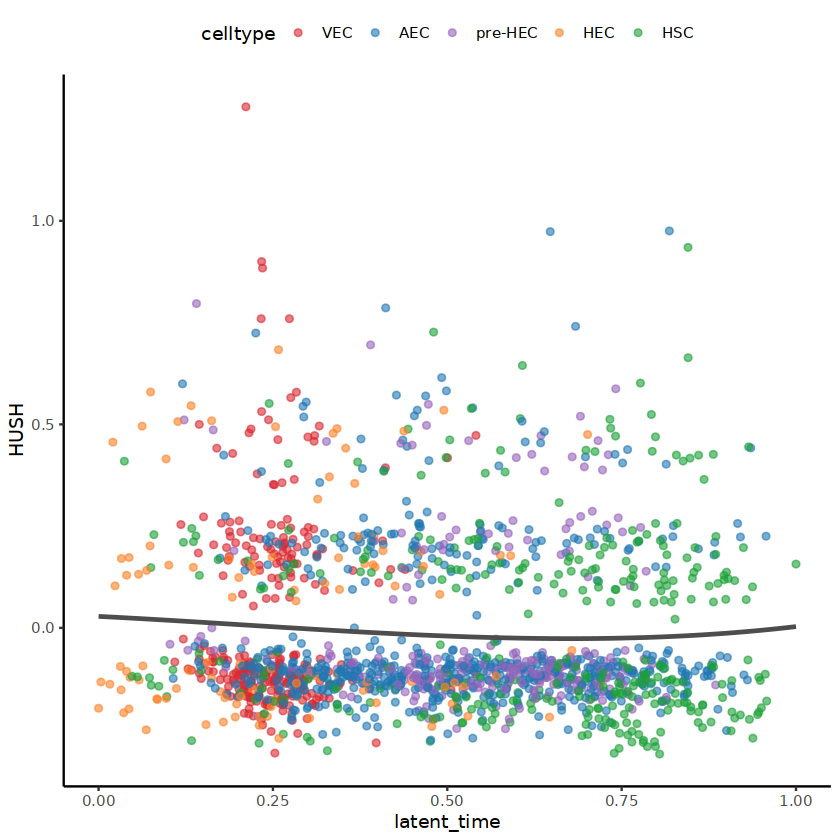

In [30]:
# plot the HUSH module
ggplot(sample_score_plot@meta.data, aes(latent_time, HUSH, color = celltype))+ geom_point(alpha = 0.6) + geom_smooth(method = lm, formula = y ~ splines::bs(x, 3), color = "grey30", se = FALSE) + theme_classic() + theme(legend.position="top") + scale_color_manual(values = c("#D82831", "#2077B2", "#9765BA", "#FF8228", "#1BA138"))

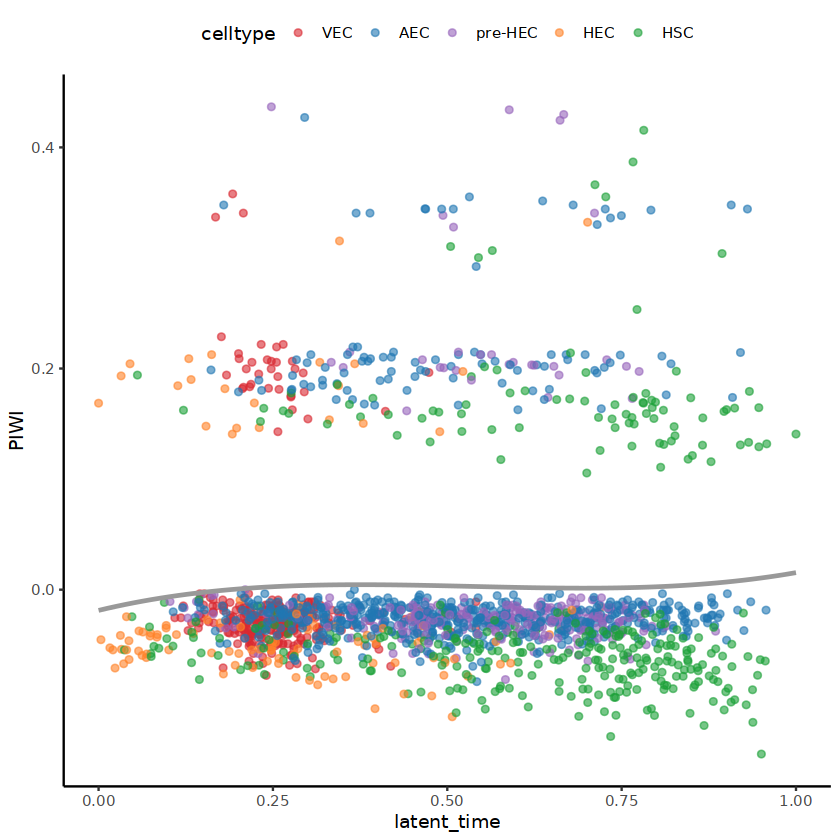

In [31]:
# plot the PIWI module
ggplot(sample_score_plot@meta.data, aes(latent_time, PIWI, color = celltype))+ geom_point(alpha = 0.6) + geom_smooth(method = lm, formula = y ~ splines::bs(x, 3), color = "grey60", se = FALSE) + theme_classic() + theme(legend.position="top") + scale_color_manual(values = c("#D82831", "#2077B2", "#9765BA", "#FF8228", "#1BA138"))

In [32]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.5 LTS

Matrix products: default
BLAS/LAPACK: /root/miniconda3/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=C.UTF-8    LC_NUMERIC=C        LC_TIME=C          
 [4] LC_COLLATE=C        LC_MONETARY=C       LC_MESSAGES=C      
 [7] LC_PAPER=C          LC_NAME=C           LC_ADDRESS=C       
[10] LC_TELEPHONE=C      LC_MEASUREMENT=C    LC_IDENTIFICATION=C

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] gtools_3.9.4       ggVolcano_0.0.2    lubridate_1.9.2    forcats_1.0.0     
 [5] stringr_1.5.0      purrr_1.0.1        readr_2.1.4        tidyr_1.3.0       
 [9] tibble_3.2.0       tidyverse_2.0.0    pheatmap_1.0.12    reshape2_1.4.4    
[13] ggrepel_0.9.3      RColorBrewer_1.1-3 Hmisc_5.0-1        Matrix_1.5-4      
[17] dplyr_1.1.1        ggpubr_0.6.0       ggplot2_3.4.2      SeuratObject_4.1.3
[21] Seurat_